# GETTING AND PREPARING THE DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import tensorflow as tf
def prepare_data(df):
    import pandas as pd
    import numpy as np
    import pandas_ta as ta
    import matplotlib.pyplot as plt
    #bollinger bands
    bbands = df.ta.bbands(close='Close', length=20)
    #macd indicator
    macd = df.ta.macd(close='Close')
    macd.drop(["MACD_12_26_9","MACDs_12_26_9"], axis=1,inplace=True)
    #rsi indicator
    rsi = df.ta.rsi(close='Close').to_frame()
    #aroon indicator
    aroon = df.ta.aroon(close="Close")
    aroon.drop(["AROOND_14","AROONU_14"], axis=1, inplace=True)
    df.drop(["Open","High","Low","Adj Close","Volume"], axis=1,inplace=True)
    df_ti = pd.concat([df,bbands,macd,rsi,aroon], axis=1)
    df_ti.dropna(inplace=True)
    window_size = 7
    horizon = 1
    df_ti_win = df_ti.copy()
    for i in range(window_size):
        df_ti_win[f'Close + {i+1}'] = df_ti["Close"].shift(periods = i+1,axis=0)
        df_ti_win[f'BBL_20_2.0 + {i+1}'] = df_ti["BBL_20_2.0"].shift(periods = i+1,axis=0)
        df_ti_win[f'BBM_20_2.0 + {i+1}'] = df_ti["BBM_20_2.0"].shift(periods = i+1,axis=0)
        df_ti_win[f'BBU_20_2.0 + {i+1}'] = df_ti["BBU_20_2.0"].shift(periods = i+1,axis=0)
        df_ti_win[f'BBB_20_2.0 + {i+1}'] = df_ti["BBB_20_2.0"].shift(periods = i+1,axis=0)
        df_ti_win[f'BBP_20_2.0 + {i+1}'] = df_ti["BBP_20_2.0"].shift(periods = i+1,axis=0)
        df_ti_win[f'MACDh_12_26_9 + {i+1}'] = df_ti["MACDh_12_26_9"].shift(periods = i+1,axis=0)
        df_ti_win[f'RSI_14 + {i+1}'] = df_ti["RSI_14"].shift(periods = i+1,axis=0)
        df_ti_win[f'AROONOSC_14 + {i+1}'] = df_ti["AROONOSC_14"].shift(periods = i+1,axis=0)
    x = df_ti_win.dropna().drop("Close",axis=1).astype(np.float32)
    y = df_ti_win.dropna()["Close"].astype(np.float32)
    return x,y

In [2]:
df = pd.read_csv("ITC.NS.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
x,y = prepare_data(df)

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle= False, test_size=0.2)
len(x_train),len(y_train),len(x_test),len(y_test)

(1719, 1719, 430, 430)

In [4]:
#using the tensorflow data api
xtrain = tf.data.Dataset.from_tensor_slices(x_train)
ytrain = tf.data.Dataset.from_tensor_slices(y_train)
xtest = tf.data.Dataset.from_tensor_slices(x_test)
ytest = tf.data.Dataset.from_tensor_slices(y_test)
# zipping the data together into train_df and test_df
train_df = tf.data.Dataset.zip((xtrain,ytrain))
test_df = tf.data.Dataset.zip((xtest,ytest))
# dividing the data into batches
batch_size = 32
train_df = train_df.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_df = test_df.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_df,test_df

(<PrefetchDataset shapes: ((None, 71), (None,)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 71), (None,)), types: (tf.float32, tf.float32)>)

# BUILDING THE MODEL

In [5]:
import tensorflow as tf
tf.random.set_seed(42)
inputs = tf.keras.Input(shape=(71,1), name="inputs")
x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="causal")(inputs)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="causal")(x)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="causal")(x)
x = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="causal")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 71, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 71, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 17, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 17, 64)            12352 

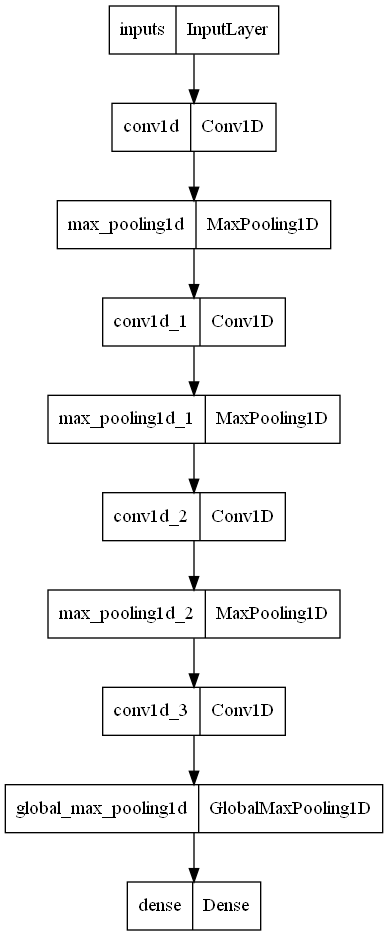

In [6]:
tf.keras.utils.plot_model(model)

In [7]:
model.compile(loss = "mae", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["mae","mse"])
history = model.fit(x_train,y_train,
                    epochs = 1000,
                    validation_data=(x_test,y_test), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                            patience=200, 
                                                            restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                               patience=100, 
                                                               verbose=1)])

Epoch 1/1000
54/54 [==============================] - 11s 19ms/step - loss: 124.1942 - mae: 124.1942 - mse: 21092.4746 - val_loss: 17.0048 - val_mae: 17.0048 - val_mse: 365.7422 - lr: 1.0000e-04
Epoch 2/1000
54/54 [==============================] - 0s 7ms/step - loss: 8.3421 - mae: 8.3421 - mse: 128.2967 - val_loss: 4.8372 - val_mae: 4.8372 - val_mse: 38.9352 - lr: 1.0000e-04
Epoch 3/1000
54/54 [==============================] - 0s 6ms/step - loss: 4.7204 - mae: 4.7204 - mse: 42.3650 - val_loss: 4.2243 - val_mae: 4.2243 - val_mse: 30.7812 - lr: 1.0000e-04
Epoch 4/1000
54/54 [==============================] - 0s 6ms/step - loss: 4.3913 - mae: 4.3913 - mse: 36.3850 - val_loss: 3.9278 - val_mae: 3.9278 - val_mse: 27.2315 - lr: 1.0000e-04
Epoch 5/1000
54/54 [==============================] - 0s 6ms/step - loss: 4.2066 - mae: 4.2066 - mse: 32.9972 - val_loss: 3.8705 - val_mae: 3.8705 - val_mse: 24.9743 - lr: 1.0000e-04
Epoch 6/1000
54/54 [==============================] - 0s 7ms/step - loss

54/54 [==============================] - 0s 7ms/step - loss: 2.0984 - mae: 2.0984 - mse: 9.0666 - val_loss: 3.1265 - val_mae: 3.1265 - val_mse: 13.4315 - lr: 1.0000e-04
Epoch 46/1000
54/54 [==============================] - 0s 7ms/step - loss: 2.0549 - mae: 2.0549 - mse: 8.8085 - val_loss: 1.9633 - val_mae: 1.9633 - val_mse: 6.9117 - lr: 1.0000e-04
Epoch 47/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.9428 - mae: 1.9428 - mse: 8.0610 - val_loss: 1.8388 - val_mae: 1.8388 - val_mse: 6.4643 - lr: 1.0000e-04
Epoch 48/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.9973 - mae: 1.9973 - mse: 8.1998 - val_loss: 1.7999 - val_mae: 1.7999 - val_mse: 6.1754 - lr: 1.0000e-04
Epoch 49/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.8845 - mae: 1.8845 - mse: 7.6821 - val_loss: 2.2515 - val_mae: 2.2515 - val_mse: 7.7414 - lr: 1.0000e-04
Epoch 50/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.9078 - mae: 1.9078 - mse: 

54/54 [==============================] - 0s 7ms/step - loss: 1.1977 - mae: 1.1977 - mse: 3.9498 - val_loss: 2.0797 - val_mae: 2.0797 - val_mse: 5.9376 - lr: 1.0000e-04
Epoch 91/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3317 - mae: 1.3317 - mse: 4.4227 - val_loss: 1.2645 - val_mae: 1.2645 - val_mse: 3.2774 - lr: 1.0000e-04
Epoch 92/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3805 - mae: 1.3805 - mse: 4.4581 - val_loss: 1.2953 - val_mae: 1.2953 - val_mse: 3.4077 - lr: 1.0000e-04
Epoch 93/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3313 - mae: 1.3313 - mse: 4.2958 - val_loss: 1.3046 - val_mae: 1.3046 - val_mse: 3.1404 - lr: 1.0000e-04
Epoch 94/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3079 - mae: 1.3079 - mse: 4.2522 - val_loss: 1.3624 - val_mae: 1.3624 - val_mse: 3.2868 - lr: 1.0000e-04
Epoch 95/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.2042 - mae: 1.2042 - mse: 3

Epoch 135/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0306 - mae: 1.0306 - mse: 3.1948 - val_loss: 1.1492 - val_mae: 1.1492 - val_mse: 2.7003 - lr: 1.0000e-04
Epoch 136/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9676 - mae: 0.9676 - mse: 3.0982 - val_loss: 1.0954 - val_mae: 1.0954 - val_mse: 2.5361 - lr: 1.0000e-04
Epoch 137/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0343 - mae: 1.0343 - mse: 3.2304 - val_loss: 1.1768 - val_mae: 1.1768 - val_mse: 2.7714 - lr: 1.0000e-04
Epoch 138/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0493 - mae: 1.0493 - mse: 3.2237 - val_loss: 1.5051 - val_mae: 1.5051 - val_mse: 3.5028 - lr: 1.0000e-04
Epoch 139/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.1628 - mae: 1.1628 - mse: 3.5325 - val_loss: 1.7066 - val_mae: 1.7066 - val_mse: 4.0841 - lr: 1.0000e-04
Epoch 140/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0258 - 

Epoch 180/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0577 - mae: 1.0577 - mse: 3.0878 - val_loss: 1.0210 - val_mae: 1.0210 - val_mse: 2.2505 - lr: 1.0000e-04
Epoch 181/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9864 - mae: 0.9864 - mse: 2.9548 - val_loss: 1.0717 - val_mae: 1.0717 - val_mse: 2.4266 - lr: 1.0000e-04
Epoch 182/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9082 - mae: 0.9082 - mse: 2.7596 - val_loss: 1.2115 - val_mae: 1.2115 - val_mse: 3.0221 - lr: 1.0000e-04
Epoch 183/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9953 - mae: 0.9953 - mse: 2.9389 - val_loss: 1.1639 - val_mae: 1.1639 - val_mse: 2.8057 - lr: 1.0000e-04
Epoch 184/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.3259 - mae: 1.3259 - mse: 3.7527 - val_loss: 1.0642 - val_mae: 1.0642 - val_mse: 2.4660 - lr: 1.0000e-04
Epoch 185/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9198 - 

Epoch 225/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0091 - mae: 1.0091 - mse: 3.0631 - val_loss: 1.1378 - val_mae: 1.1378 - val_mse: 2.6116 - lr: 1.0000e-04
Epoch 226/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9535 - mae: 0.9535 - mse: 2.7436 - val_loss: 1.3352 - val_mae: 1.3352 - val_mse: 2.8424 - lr: 1.0000e-04
Epoch 227/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9599 - mae: 0.9599 - mse: 2.7963 - val_loss: 1.3615 - val_mae: 1.3615 - val_mse: 2.9663 - lr: 1.0000e-04
Epoch 228/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9002 - mae: 0.9002 - mse: 2.6485 - val_loss: 1.0043 - val_mae: 1.0043 - val_mse: 2.1321 - lr: 1.0000e-04
Epoch 229/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8786 - mae: 0.8786 - mse: 2.5847 - val_loss: 1.0895 - val_mae: 1.0895 - val_mse: 2.2827 - lr: 1.0000e-04
Epoch 230/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8952 - 

Epoch 270/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8353 - mae: 0.8353 - mse: 2.4802 - val_loss: 1.1489 - val_mae: 1.1489 - val_mse: 2.4834 - lr: 1.0000e-04
Epoch 271/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8850 - mae: 0.8850 - mse: 2.6009 - val_loss: 1.0677 - val_mae: 1.0677 - val_mse: 2.3263 - lr: 1.0000e-04
Epoch 272/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9144 - mae: 0.9144 - mse: 2.5645 - val_loss: 1.0764 - val_mae: 1.0764 - val_mse: 2.2658 - lr: 1.0000e-04
Epoch 273/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8361 - mae: 0.8361 - mse: 2.4387 - val_loss: 1.0037 - val_mae: 1.0037 - val_mse: 2.1525 - lr: 1.0000e-04
Epoch 274/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.9263 - mae: 0.9263 - mse: 2.6257 - val_loss: 1.0112 - val_mae: 1.0112 - val_mse: 2.1340 - lr: 1.0000e-04
Epoch 275/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8667 - 

Epoch 315/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7973 - mae: 0.7973 - mse: 2.2849 - val_loss: 0.9686 - val_mae: 0.9686 - val_mse: 1.9736 - lr: 1.0000e-04
Epoch 316/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.0322 - mae: 1.0322 - mse: 2.8833 - val_loss: 0.9938 - val_mae: 0.9938 - val_mse: 2.0428 - lr: 1.0000e-04
Epoch 317/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8477 - mae: 0.8477 - mse: 2.3959 - val_loss: 1.4948 - val_mae: 1.4948 - val_mse: 3.3912 - lr: 1.0000e-04
Epoch 318/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.8938 - mae: 0.8938 - mse: 2.5383 - val_loss: 1.1231 - val_mae: 1.1231 - val_mse: 2.5126 - lr: 1.0000e-04
Epoch 319/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.0029 - mae: 1.0029 - mse: 2.7537 - val_loss: 1.0780 - val_mae: 1.0780 - val_mse: 2.2334 - lr: 1.0000e-04
Epoch 320/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.9469 - 

Epoch 360/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8746 - mae: 0.8746 - mse: 2.3912 - val_loss: 1.0508 - val_mae: 1.0508 - val_mse: 2.1499 - lr: 1.0000e-04
Epoch 361/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8270 - mae: 0.8270 - mse: 2.3424 - val_loss: 0.9905 - val_mae: 0.9905 - val_mse: 1.9964 - lr: 1.0000e-04
Epoch 362/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.9181 - mae: 0.9181 - mse: 2.5074 - val_loss: 1.6423 - val_mae: 1.6423 - val_mse: 4.0603 - lr: 1.0000e-04
Epoch 363/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.1532 - mae: 1.1532 - mse: 3.0834 - val_loss: 1.1373 - val_mae: 1.1373 - val_mse: 2.5267 - lr: 1.0000e-04
Epoch 364/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8334 - mae: 0.8334 - mse: 2.3312 - val_loss: 1.0302 - val_mae: 1.0302 - val_mse: 2.2710 - lr: 1.0000e-04
Epoch 365/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8691 - 

Epoch 405/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8057 - mae: 0.8057 - mse: 2.1475 - val_loss: 0.9979 - val_mae: 0.9979 - val_mse: 2.0181 - lr: 1.0000e-04
Epoch 406/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8107 - mae: 0.8107 - mse: 2.2408 - val_loss: 1.1101 - val_mae: 1.1101 - val_mse: 2.3015 - lr: 1.0000e-04
Epoch 407/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8405 - mae: 0.8405 - mse: 2.1957 - val_loss: 1.2482 - val_mae: 1.2482 - val_mse: 2.6909 - lr: 1.0000e-04
Epoch 408/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.0607 - mae: 1.0607 - mse: 2.8336 - val_loss: 0.9762 - val_mae: 0.9762 - val_mse: 2.0522 - lr: 1.0000e-04
Epoch 409/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7410 - mae: 0.7410 - mse: 2.0886 - val_loss: 1.0138 - val_mae: 1.0138 - val_mse: 2.2023 - lr: 1.0000e-04
Epoch 410/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7525 - 

Epoch 450/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8026 - mae: 0.8026 - mse: 2.1313 - val_loss: 1.0351 - val_mae: 1.0351 - val_mse: 2.2158 - lr: 1.0000e-04
Epoch 451/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.9243 - mae: 0.9243 - mse: 2.3628 - val_loss: 1.2713 - val_mae: 1.2713 - val_mse: 2.7023 - lr: 1.0000e-04
Epoch 452/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8432 - mae: 0.8432 - mse: 2.1059 - val_loss: 1.0965 - val_mae: 1.0965 - val_mse: 2.3299 - lr: 1.0000e-04
Epoch 453/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.0190 - mae: 1.0190 - mse: 2.6476 - val_loss: 1.0495 - val_mae: 1.0495 - val_mse: 2.2582 - lr: 1.0000e-04
Epoch 454/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7600 - mae: 0.7600 - mse: 2.0275 - val_loss: 0.9760 - val_mae: 0.9760 - val_mse: 2.0832 - lr: 1.0000e-04
Epoch 455/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8689 - 

Epoch 495/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8616 - mae: 0.8616 - mse: 2.1979 - val_loss: 1.0885 - val_mae: 1.0885 - val_mse: 2.3824 - lr: 1.0000e-04
Epoch 496/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.0589 - mae: 1.0589 - mse: 2.5458 - val_loss: 1.4746 - val_mae: 1.4746 - val_mse: 3.2153 - lr: 1.0000e-04
Epoch 497/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8236 - mae: 0.8236 - mse: 1.9887 - val_loss: 0.9679 - val_mae: 0.9679 - val_mse: 2.0032 - lr: 1.0000e-04
Epoch 498/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7237 - mae: 0.7237 - mse: 1.9007 - val_loss: 0.9413 - val_mae: 0.9413 - val_mse: 1.9393 - lr: 1.0000e-04
Epoch 499/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7221 - mae: 0.7221 - mse: 1.8947 - val_loss: 0.9957 - val_mae: 0.9957 - val_mse: 2.0099 - lr: 1.0000e-04
Epoch 500/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7299 - 

Epoch 540/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8774 - mae: 0.8774 - mse: 2.2014 - val_loss: 1.3164 - val_mae: 1.3164 - val_mse: 2.8202 - lr: 1.0000e-04
Epoch 541/1000
54/54 [==============================] - 0s 6ms/step - loss: 1.0248 - mae: 1.0248 - mse: 2.4745 - val_loss: 0.9610 - val_mae: 0.9610 - val_mse: 1.9316 - lr: 1.0000e-04
Epoch 542/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7936 - mae: 0.7936 - mse: 2.0152 - val_loss: 1.3927 - val_mae: 1.3927 - val_mse: 3.1844 - lr: 1.0000e-04
Epoch 543/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.8248 - mae: 0.8248 - mse: 2.0022 - val_loss: 0.9735 - val_mae: 0.9735 - val_mse: 1.9507 - lr: 1.0000e-04
Epoch 544/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7993 - mae: 0.7993 - mse: 2.0008 - val_loss: 0.9896 - val_mae: 0.9896 - val_mse: 2.0164 - lr: 1.0000e-04
Epoch 545/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7788 - 

Epoch 585/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.6768 - mae: 0.6768 - mse: 1.7694 - val_loss: 0.9875 - val_mae: 0.9875 - val_mse: 2.0921 - lr: 1.0000e-04
Epoch 586/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7660 - mae: 0.7660 - mse: 1.9016 - val_loss: 0.9874 - val_mae: 0.9874 - val_mse: 1.8902 - lr: 1.0000e-04
Epoch 587/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7337 - mae: 0.7337 - mse: 1.8036 - val_loss: 0.9300 - val_mae: 0.9300 - val_mse: 1.9733 - lr: 1.0000e-04
Epoch 588/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.7250 - mae: 0.7250 - mse: 1.8056 - val_loss: 0.9385 - val_mae: 0.9385 - val_mse: 1.8427 - lr: 1.0000e-04
Epoch 589/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.6996 - mae: 0.6996 - mse: 1.7910 - val_loss: 1.0060 - val_mae: 1.0060 - val_mse: 2.0669 - lr: 1.0000e-04
Epoch 590/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.7892 - 

Epoch 629/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5906 - mae: 0.5906 - mse: 1.6008 - val_loss: 0.9185 - val_mae: 0.9185 - val_mse: 1.8406 - lr: 1.0000e-05
Epoch 630/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5785 - mae: 0.5785 - mse: 1.5754 - val_loss: 0.9540 - val_mae: 0.9540 - val_mse: 1.9302 - lr: 1.0000e-05
Epoch 631/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5952 - mae: 0.5952 - mse: 1.5905 - val_loss: 0.9214 - val_mae: 0.9214 - val_mse: 1.8575 - lr: 1.0000e-05
Epoch 632/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5787 - mae: 0.5787 - mse: 1.5625 - val_loss: 0.9115 - val_mae: 0.9115 - val_mse: 1.8440 - lr: 1.0000e-05
Epoch 633/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5789 - mae: 0.5789 - mse: 1.5864 - val_loss: 0.9174 - val_mae: 0.9174 - val_mse: 1.8417 - lr: 1.0000e-05
Epoch 634/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5758 - 

Epoch 674/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5773 - mae: 0.5773 - mse: 1.5528 - val_loss: 0.9209 - val_mae: 0.9209 - val_mse: 1.8819 - lr: 1.0000e-05
Epoch 675/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5861 - mae: 0.5861 - mse: 1.5622 - val_loss: 0.9391 - val_mae: 0.9391 - val_mse: 1.8993 - lr: 1.0000e-05
Epoch 676/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5696 - mae: 0.5696 - mse: 1.5525 - val_loss: 0.9204 - val_mae: 0.9204 - val_mse: 1.8604 - lr: 1.0000e-05
Epoch 677/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.6268 - mae: 0.6268 - mse: 1.6415 - val_loss: 0.9420 - val_mae: 0.9420 - val_mse: 1.9115 - lr: 1.0000e-05
Epoch 678/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5771 - mae: 0.5771 - mse: 1.5729 - val_loss: 0.9411 - val_mae: 0.9411 - val_mse: 1.8941 - lr: 1.0000e-05
Epoch 679/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.5958 - 

Epoch 719/1000
54/54 [==============================] - 0s 5ms/step - loss: 0.5692 - mae: 0.5692 - mse: 1.5500 - val_loss: 0.9336 - val_mae: 0.9336 - val_mse: 1.8719 - lr: 1.0000e-05
Epoch 720/1000
54/54 [==============================] - 0s 6ms/step - loss: 0.5765 - mae: 0.5765 - mse: 1.5634 - val_loss: 0.9550 - val_mae: 0.9550 - val_mse: 1.9309 - lr: 1.0000e-05
Epoch 721/1000
54/54 [==============================] - 0s 7ms/step - loss: 0.5781 - mae: 0.5781 - mse: 1.5667 - val_loss: 0.9320 - val_mae: 0.9320 - val_mse: 1.8672 - lr: 1.0000e-05
Epoch 722/1000
45/54 [========================>.....] - ETA: 0s - loss: 0.5753 - mae: 0.5753 - mse: 1.4962
Epoch 00722: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
54/54 [==============================] - 0s 6ms/step - loss: 0.5738 - mae: 0.5738 - mse: 1.5568 - val_loss: 0.9296 - val_mae: 0.9296 - val_mse: 1.8695 - lr: 1.0000e-05


# EVALUATING THE MODEL

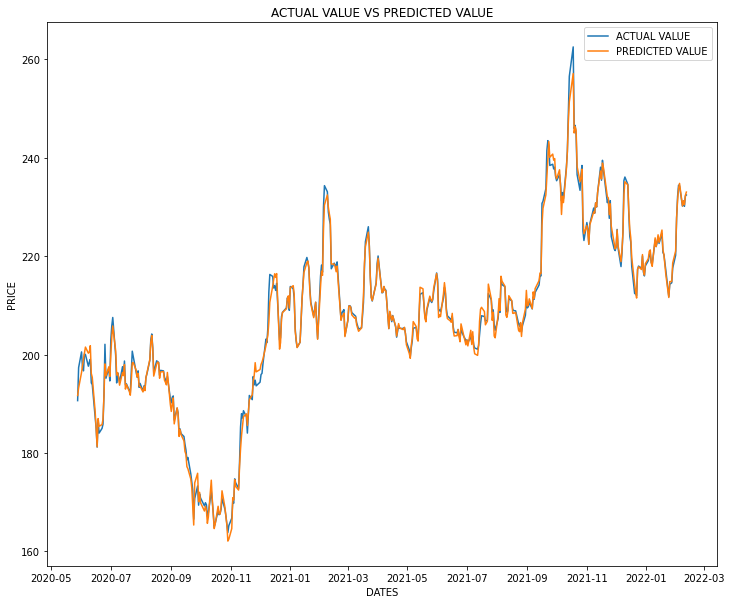

In [8]:
preds = tf.squeeze(model.predict(test_df)).numpy()
plt.figure(figsize=(12,10))
plt.plot(y_test.index, y_test,label="ACTUAL VALUE")
plt.plot(y_test.index, preds,label="PREDICTED VALUE")
plt.xlabel("DATES")
plt.ylabel("PRICE")
plt.title("ACTUAL VALUE VS PREDICTED VALUE")
plt.legend()

In [9]:
model.save("conv1d itc")

INFO:tensorflow:Assets written to: conv1d itc\assets
